In [1]:
import json
import pandas as pd
import glob
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
import re
import collections
import os
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from scipy.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# paths = [x for x in glob.glob('data_withmeta/*.csv')]

In [3]:
# df = pd.concat(map(pd.read_csv, paths))

In [4]:
# df.to_csv('data_withmeta/combined_data_withmeta.csv', index=None)

In [2]:
df = pd.read_csv('data_withmeta/combined_data_withmeta.csv')

In [3]:
feature_list = ['danceability', 'energy', 'key', 'loudness', 'mode', \
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
       'valence', 'tempo', 'num_tracks', 'num_albums',
       'num_followers', 'num_edits', 'duration_ms_playlist', 'num_artists']

In [41]:
playlist_0 = df[df['playlist_pid'] == 0]

In [42]:
playlist_376000 = df[df['playlist_pid'] == 376000]

In [45]:
playlist_376000 = playlist_376000[feature_list+['playlist_pid']]

In [46]:
playlist_0 = playlist_0[feature_list+['playlist_pid']]

In [48]:
df_merged = playlist_0.append(playlist_376000, ignore_index=True)

/tmp/ipykernel_27070/2220804513.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = playlist_0.append(playlist_376000, ignore_index=True)


In [49]:
df_merged

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0           0.904   0.813  4.0    -7.105   0.0       0.1210       0.03110   
1           0.774   0.838  5.0    -3.914   0.0       0.1140       0.02490   
2           0.664   0.758  2.0    -6.583   0.0       0.2100       0.00238   
3           0.892   0.714  4.0    -6.055   0.0       0.1410       0.20100   
4           0.853   0.606  0.0    -4.596   1.0       0.0713       0.05610   
..            ...     ...  ...       ...   ...          ...           ...   
142         0.275   0.215  2.0   -13.697   1.0       0.0310       0.56300   
143         0.393   0.678  7.0    -6.584   1.0       0.0377       0.17200   
144         0.663   0.482  1.0   -12.093   1.0       0.0479       0.18600   
145         0.324   0.335  0.0   -15.595   1.0       0.0355       0.09900   
146         0.727   0.772  2.0    -5.854   1.0       0.1150       0.11800   

     instrumentalness  liveness  valence    tempo  playlist_pid  
0            0.006970    0.0471   0.8100  125.461             0  
1            0.025000    0.2420   0.9240  143.040             0  
2            0.000000    0.0598   0.7010   99.259             0  
3            0.000234    0.0521   0.8170  100.972             0  
4            0.000000    0.3130   0.6540   94.759             0  
..                ...       ...      ...      ...           ...  
142          0.000000    0.0945   0.0776  166.568        376000  
143          0.000000    0.0727   0.3580  137.380        376000  
144          0.000000    0.0521   0.3140  144.130        376000  
145          0.000001    0.0995   0.1410  119.513        376000  
146          0.000883    0.9880   0.8270  102.304        376000  

[147 rows x 12 columns]

In [57]:
sns.set_palette("pastel")

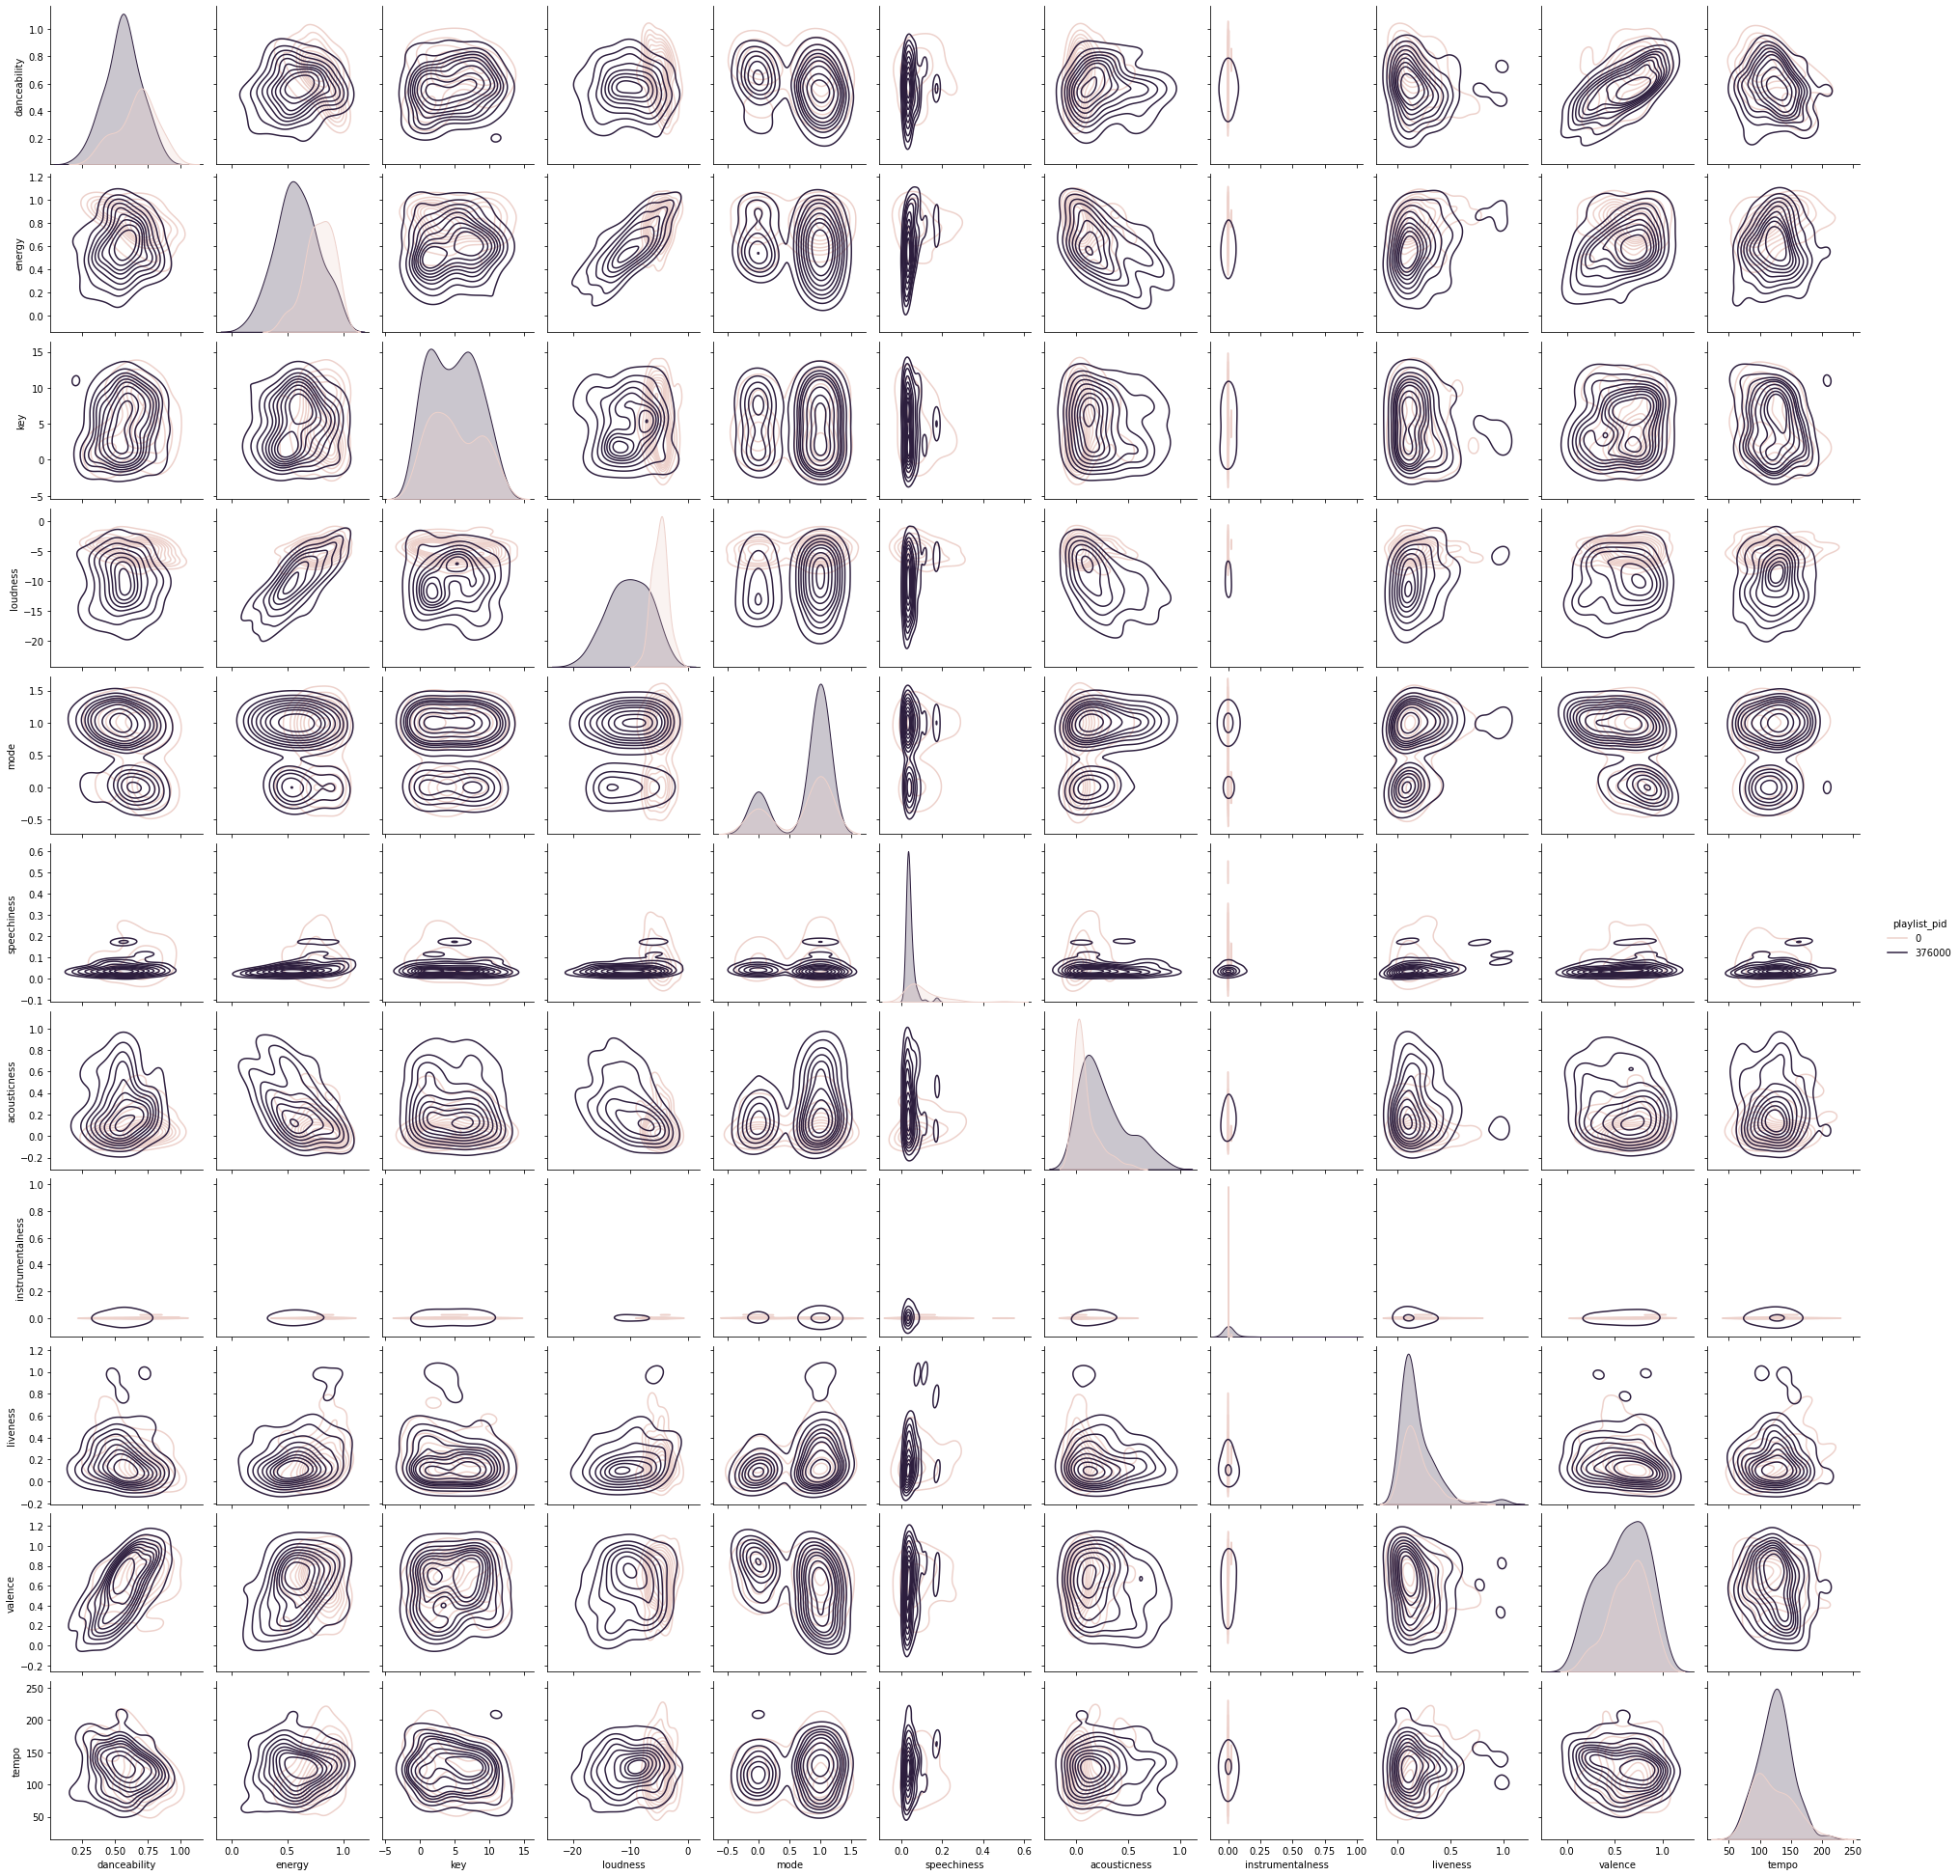

In [58]:
sns.pairplot(df_merged, kind="kde",hue="playlist_pid")

<AxesSubplot:xlabel='loudness', ylabel='loudness'>

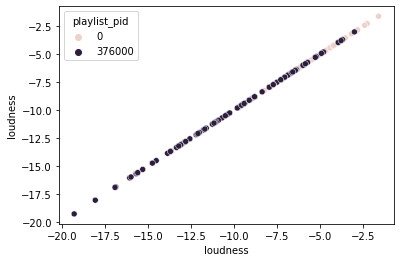

In [61]:
sns.scatterplot(data=df_merged, x="loudness", y="loudness", hue='playlist_pid')

In [153]:
X_376000 = playlist_376000.drop(columns='playlist_pid').T
y_376000 = playlist_376000.playlist_pid
scaler = StandardScaler()
X_376000 = scaler.fit_transform(X_376000)

pca = decomposition.PCA(n_components=1)
pca.fit(X_376000)
X_376000 = pca.transform(X_376000)

In [154]:
X_376000

array([[-2.83705826],
       [-2.83197645],
       [-1.59720399],
       [-5.90832759],
       [-2.77720968],
       [-2.98485975],
       [-2.9217263 ],
       [-2.99145038],
       [-2.94412593],
       [-2.82950434],
       [30.62344267]])

In [155]:
X_0 = playlist_0.drop(columns='playlist_pid').T
y_0 = playlist_0.playlist_pid
scaler = StandardScaler()
X_0 = scaler.fit_transform(X_0)

pca = decomposition.PCA(n_components=1)
pca.fit(X_0)
X_0 = pca.transform(X_0)

In [156]:
np.linalg.norm(X_376000 - X_0)

8.464757557839327

In [93]:
from sklearn.cross_decomposition import CCA
X_cca = playlist_376000.drop(columns='playlist_pid').T
Y_cca = playlist_0.drop(columns='playlist_pid').T
cca = CCA(n_components=1)
cca.fit(X_cca, Y_cca)

X_c, Y_c = cca.transform(X_cca, Y_cca)

In [94]:
X_c

array([[ 0.73770323],
       [ 0.74411636],
       [ 0.51951587],
       [ 1.30212914],
       [ 0.80141169],
       [ 0.79288434],
       [ 0.79921995],
       [ 0.80092049],
       [ 0.79809237],
       [ 0.74432779],
       [-8.04032122]])

In [95]:
Y_c

array([[ 0.82700503],
       [ 0.83419449],
       [ 0.58240525],
       [ 1.45975685],
       [ 0.89842564],
       [ 0.88886602],
       [ 0.89596858],
       [ 0.89787497],
       [ 0.8947045 ],
       [ 0.83443151],
       [-9.01363283]])

In [98]:
pearsonr(X_c.flatten(),Y_c.flatten())

(0.9999999999999999, 9.370452282996262e-72)

In [103]:
pearsonr(X_376000.flatten(),X_0.flatten())

(0.9991133957704856, 1.0755911111716379e-13)

In [4]:
unique_playlist = list(df['playlist_pid'].unique())

In [5]:
unique_playlist = list(df['playlist_pid'].unique())
df_similarity = df[feature_list + ['playlist_pid','track_uri']]
df_similarity = df_similarity.dropna()

In [63]:
df_similarity = df_similarity.dropna()

In [234]:
df_209_groundtruth = df_similarity[df_similarity['playlist_pid'] == 209]
X_209, y_209 = train_test_split(df_209_groundtruth, test_size=0.3, random_state=42)

In [235]:
def cca_similarity(X_cca,Y_cca):
    cca = CCA(n_components=1)
    cca.fit(X_cca, Y_cca)

    X_c, Y_c = cca.transform(X_cca, Y_cca)
    return (pearsonr(X_c.flatten(),Y_c.flatten())[0])

In [403]:
def pca_process (X,n_com):
    scaler = StandardScaler()
    X_0 = scaler.fit_transform(X) 
    pca = decomposition.PCA(n_components=n_com)
    pca.fit(X_0)
    X_0 = pca.transform(X_0)
    return X_0
def pca_similarity (X,Y):
    return pearsonr(pca_process(X).flatten(),pca_process(Y).flatten())[0]

def matrix_norm (X,Y,n_com):
    return np.linalg.norm(pca_process(X,n_com).flatten() - pca_process(Y,n_com).flatten())
def average_norm (X,Y):
    return np.linalg.norm(np.array(X.T.mean()) - np.array(Y.T.mean()))

In [404]:
def similarity_vector(df, pid, method):
    X_cca = df.drop(columns=['playlist_pid','track_uri']).T
    similarity_list = []
    list_temp = unique_playlist.copy()
    list_temp.remove(pid)
#     print (unique_playlist)
    for j in list_temp:
        Y_cca = df_similarity[df_similarity['playlist_pid'] == j]
        Y_cca = Y_cca.drop(columns=['playlist_pid','track_uri']).T
        try:
            if method == 'pca':
                sim = pca_similarity(X_cca,Y_cca)
            elif method == 'matrix norms':
                sim = matrix_norm(X_cca,Y_cca,2)
            elif method == 'cca':
                sim = cca_similarity(X_cca,Y_cca)
            elif method == 'average':
                sim = average_norm(X_cca,Y_cca)
                
            similarity_list.append({'pid_1':pid, 'pid_2':j, 'similarity': sim})
                
        except Exception as e:
            print (e)
            print (pid,j)
    return similarity_list

In [405]:
l = similarity_vector(X_209,209, 'matrix norms')

In [406]:
df_sim_result = pd.DataFrame(l)

In [408]:
df_sim_result.sort_values("similarity").head(5)

pid_1   pid_2  similarity
799     209  516406    0.144355
2544    209  341956    0.158380
5547    209  290280    0.170494
847     209  516515    0.176844
3481    209  376402    0.179922

In [409]:
def get_pca_comp (df,n_com):
    X_cca = df
    X_cca = X_cca.drop(columns=['playlist_pid','track_uri']).T
    return pca_process(X_cca,n_com)

In [410]:
def preprocess (df):
    df_temp = df.copy()
    scaler = StandardScaler()
    df_temp = df_temp.drop(columns=['playlist_pid','track_uri'])
    data_tranformed = df_temp.T
    data_tranformed = scaler.fit_transform(data_tranformed) 
    df_temp = pd.DataFrame(data_tranformed.T, index=df_temp.index,columns=df_temp.columns)
    df_temp['playlist_pid'] = df.playlist_pid
    df_temp['track_uri'] = df.track_uri
    return df_temp

In [366]:
playlist_feature = get_pca_comp (X_209,1)

In [392]:
here = preprocess(X_209)

In [395]:
here.iloc[0].drop(labels=['playlist_pid','track_uri']).values

array([-0.3016746627844289, -0.2864618623442739, -0.31544699020369166,
       -0.38810304403796547, -0.31544699020369166, -0.3135673485788688,
       -0.314635406623628, -0.31544691115334295, -0.3120320151395275,
       -0.2985126488361288, 3.161327879905547], dtype=object)

In [370]:
get_pca_comp (X_209,1)

array([[-1.80053616],
       [-1.80852565],
       [-1.11365306],
       [-2.97894967],
       [-1.77908093],
       [-1.9135769 ],
       [-1.88834063],
       [-1.92424959],
       [-1.89210807],
       [-1.81388224],
       [18.91290289]])

In [402]:
np.linalg.norm(get_pca_comp (X_209,1).flatten() - here.iloc[0].drop(labels=['playlist_pid','track_uri']).values.T)

16.57060749985832

In [442]:
def track_similarity (df, lst_playlist):
    playlist_feature = get_pca_comp (df,1).flatten().T
#     print (playlist_feature)
    track_sim = []
    for i in lst_playlist:
        df_temp = df_similarity[df_similarity['playlist_pid'] == i]
        df_temp = preprocess(df_temp)
        for j,r in df_temp.iterrows():
            r_temp = r.copy()
            r_temp = r_temp.drop(labels=['playlist_pid','track_uri'])
            track_sim.append({'track_uri':r['track_uri'], "similarity": np.linalg.norm(playlist_feature - r_temp)})
    return track_sim

In [412]:
top_sim_list = list(df_sim_result.sort_values("similarity").head(20).pid_2)+list(df_sim_result.sort_values("similarity").tail(5).pid_2)

In [413]:
track_similar = track_similarity(X_209,top_sim_list)

[-1.80053616 -1.80852565 -1.11365306 -2.97894967 -1.77908093 -1.9135769
 -1.88834063 -1.92424959 -1.89210807 -1.81388224 18.91290289]


In [414]:
df_track_209 = pd.DataFrame(track_similar)

In [415]:
df_track_209.sort_values("similarity")

track_uri  similarity
1396  spotify:track:0qAIiGFKLdV1xpNlEhjpq8   16.565334
1279  spotify:track:2vwlzO0Qp8kfEtzTsCXfyE   16.565352
1039  spotify:track:2D39m99GbfbLccyMJbSXvD   16.565379
574   spotify:track:4ZOullI0mMvUwBFHwOBW7G   16.565389
1261  spotify:track:6jG2YzhxptolDzLHTGLt7S   16.565398
...                                    ...         ...
1773  spotify:track:579Mb1bAVxA7m0Kio6Dn5F   16.691186
1801  spotify:track:6hqopvCkT7JW6sSwMw2tFD   16.696647
1889  spotify:track:1X2HqsjmipJvBLdPyFJ1FR   16.710734
1763  spotify:track:0P3tkfR6n3msaCGTaDqrcl   16.711093
1739  spotify:track:5yiinlL1tEG7GcNsuvEHRF   16.982519

[1963 rows x 2 columns]

In [425]:
def r_precision (G,R):
    set1 = set(G)
    set2 = set(R)
    set_inter = set2.intersection(set1)
    return len(set_inter)/len(G), list(set_inter)

In [437]:
lst1 = list(y_209.track_uri) 
lst2 = list(df_track_209.sort_values("similarity").head(250).track_uri) + list(df_track_209.sort_values("similarity").tail(250).track_uri)

In [438]:
here, ho = r_precision(lst1,lst2)

In [439]:
here

0.125

In [440]:
df_track_209[df_track_209.track_uri.isin(ho)]

track_uri  similarity
341  spotify:track:6ihL9TjfRjadfEePzXXyVF   16.565720
504  spotify:track:5bcTCxgc7xVfSaMV3RuVke   16.575442

In [441]:
df[df.track_uri.isin(ho)]

pos               artist_name                             track_uri  \
14547    33             Calvin Harris  spotify:track:5bcTCxgc7xVfSaMV3RuVke   
14548     1             Calvin Harris  spotify:track:5bcTCxgc7xVfSaMV3RuVke   
14549   141             Calvin Harris  spotify:track:5bcTCxgc7xVfSaMV3RuVke   
14550    10             Calvin Harris  spotify:track:5bcTCxgc7xVfSaMV3RuVke   
14551    50             Calvin Harris  spotify:track:5bcTCxgc7xVfSaMV3RuVke   
...     ...                       ...                                   ...   
326984    5  The All-American Rejects  spotify:track:6ihL9TjfRjadfEePzXXyVF   
326985    6  The All-American Rejects  spotify:track:6ihL9TjfRjadfEePzXXyVF   
326986  129  The All-American Rejects  spotify:track:6ihL9TjfRjadfEePzXXyVF   
326987  100  The All-American Rejects  spotify:track:6ihL9TjfRjadfEePzXXyVF   
326988   68  The All-American Rejects  spotify:track:6ihL9TjfRjadfEePzXXyVF   

                                   artist_uri      track_name  \
14547   spotify:artist:7CajNmpbOovFoOoasH2HaY           Feels   
14548   spotify:artist:7CajNmpbOovFoOoasH2HaY           Feels   
14549   spotify:artist:7CajNmpbOovFoOoasH2HaY           Feels   
14550   spotify:artist:7CajNmpbOovFoOoasH2HaY           Feels   
14551   spotify:artist:7CajNmpbOovFoOoasH2HaY           Feels   
...                                       ...             ...   
326984  spotify:artist:3vAaWhdBR38Q02ohXqaNHT  Gives You Hell   
326985  spotify:artist:3vAaWhdBR38Q02ohXqaNHT  Gives You Hell   
326986  spotify:artist:3vAaWhdBR38Q02ohXqaNHT  Gives You Hell   
326987  spotify:artist:3vAaWhdBR38Q02ohXqaNHT  Gives You Hell   
326988  spotify:artist:3vAaWhdBR38Q02ohXqaNHT  Gives You Hell   

                                   album_uri  duration_ms  \
14547   spotify:album:2HaqChIDc5go3qxVunBDK0       223413   
14548   spotify:album:2HaqChIDc5go3qxVunBDK0       223413   
14549   spotify:album:2HaqChIDc5go3qxVunBDK0       223413   
14550   spotify:album:2HaqChIDc5go3qxVunBDK0       223413   
14551   spotify:album:2HaqChIDc5go3qxVunBDK0       223413   
...                                      ...          ...   
326984  spotify:album:3BCMpDOcQlbCZpf5vnTadZ       213106   
326985  spotify:album:3BCMpDOcQlbCZpf5vnTadZ       213106   
326986  spotify:album:3BCMpDOcQlbCZpf5vnTadZ       213106   
326987  spotify:album:3BCMpDOcQlbCZpf5vnTadZ       213106   
326988  spotify:album:3BCMpDOcQlbCZpf5vnTadZ       213106   

                       album_name  playlist_pid          name  ...  loudness  \
14547      Funk Wav Bounces Vol.1        516058   New 2017 ;)  ...    -3.105   
14548      Funk Wav Bounces Vol.1        516164    grad party  ...    -3.105   
14549      Funk Wav Bounces Vol.1        516247         🏃🏼‍♀️  ...    -3.105   
14550      Funk Wav Bounces Vol.1        516339   Summer 2017  ...    -3.105   
14551      Funk Wav Bounces Vol.1        516613        Sports  ...    -3.105   
...                           ...           ...           ...  ...       ...   
326984  When The World Comes Down        290297      Far away  ...    -6.440   
326985  When The World Comes Down        290450     Right now  ...    -6.440   
326986  When The World Comes Down        290470        vibin'  ...    -6.440   
326987  When The World Comes Down        290756        Hippie  ...    -6.440   
326988  When The World Comes Down        290800  white people  ...    -6.440   

        mode  speechiness  acousticness  instrumentalness  liveness  valence  \
14547    0.0       0.0571        0.0642               0.0    0.0943    0.872   
14548    0.0       0.0571        0.0642               0.0    0.0943    0.872   
14549    0.0       0.0571        0.0642               0.0    0.0943    0.872   
14550    0.0       0.0571        0.0642               0.0    0.0943    0.872   
14551    0.0       0.0571        0.0642               0.0    0.0943    0.872   
...      ...          ...           ...               ...       ...      ...   
326984   1.0       0.038

In [233]:
df[df['playlist_pid'] == 209]

pos               artist_name                             track_uri  \
244866   28                     Queen  spotify:track:1AhDOtG9vPSOmsWgNW0BEY   
245884    5   Macklemore & Ryan Lewis  spotify:track:3bidbhpOYeV4knp8AIu8Xn   
246151   35              Charlie Puth  spotify:track:4iLqG9SeJSnt0cSPICSjxv   
247444   46              Alessia Cara  spotify:track:0prNGof3XqfTvNDxHonvdK   
248698    8  The All-American Rejects  spotify:track:6ihL9TjfRjadfEePzXXyVF   
249526   40             Calvin Harris  spotify:track:5bcTCxgc7xVfSaMV3RuVke   
249630   34                Liam Payne  spotify:track:6EpRaXYhGOB3fj4V2uDkMJ   
250094   42                     Logic  spotify:track:5tz69p7tJuGPeMGwNTxYuV   
250253   29                Luis Fonsi  spotify:track:5CtI0qwDJkDQGwXD1H1cLb   
250954   44               Niall Horan  spotify:track:38yBBH2jacvDxrznF7h08J   
251114   43                    Khalid  spotify:track:5bgwqaRSS3M8WHWruHgSL5   
251156   50              Taylor Swift  spotify:track:6uFsE1JgZ20EXyU0JQZbUR   
251173   39            Camila Cabello  spotify:track:0ofbQMrRDsUaVKq2mGLEAb   
251612    4               Mike Posner  spotify:track:17Fd6Yb7mSbinKG8LoWfFl   
251694    2             Fifth Harmony  spotify:track:4tCtwWceOPWzenK2HAIJSb   
253633   30                   Rihanna  spotify:track:5i66xrvSh1MjjyDd6zcwgj   
253681   32                   Rihanna  spotify:track:39afswHs17v53znQm1gDTY   
254288   38              Andy Grammer  spotify:track:4nMlau89VAjmV7agkl7OY3   
255739   22         Twenty One Pilots  spotify:track:36tghkPg1AO4HsAzo6YpPp   
255842    0              Lukas Graham  spotify:track:7129iqBafaphfc3WPCGC0L   
255946    9               Jon Bellion  spotify:track:1CnPYaKxTVb4LWOtiGOm0m   
256006   23               Niall Horan  spotify:track:3UwT4FadEGWyMdaSwYcUBY   
256299   36          Bowling For Soup  spotify:track:5oQcOu1omDykbIPSdSQQNJ   
259788   27       Jay & The Americans  spotify:track:252YuUdUaC5OojaBU0H1CP   
260379   37                    Khalid  spotify:track:5Z3GHaZ6ec9bsiI5BenrbY   
261891   16                Bruno Mars  spotify:track:0KKkJNfGyhkQ5aFogxQAPU   
262754    3                    G-Eazy  spotify:track:40YcuQysJ0KlGQTeGUosTC   
263834   26              Andy Grammer  spotify:track:4wTChU0tU44TAMC0xcQizi   
263877    1              Andy Grammer  spotify:track:3gHc5XTAywdFQUsHS6DD7G   
264421   18              Harry Styles  spotify:track:5kRPPEWFJIMox5qIkQkiz5   
270765   19              Harry Styles  spotify:track:33SNO8AaciGbNaQFkxvPrW   
270775   20              Harry Styles  spotify:track:5LABCxgmP7DATATIJXOh6n   
272907    7         Twenty One Pilots  spotify:track:4rfaoyaZvNa60cj3OKSQV9   
274503   10               Demi Lovato  spotify:track:6WjmPTZKeDylStKmGHLcqQ   
274511   31              Selena Gomez  spotify:track:6ZANrVuAMp2rpjhfbOuJly   
274575   41                   Tove Lo  spotify:track:14OxJlLdcHNpgsm4DRwDOB   
275446   45              Selena Gomez  spotify:track:1sCxVKWImDZSZKvG0U9B23   
275737    6                     Train  spotify:track:77hjM9bMmgfTGJXv14UFmi   
275830   48                    Halsey  spotify:track:7y9iMe8SOB6z3NoHE2OfXl   
278011   11                 Glee Cast  spotify:track:6rjnRocdCULjLF61x2NR5e   
278012   12                 Glee Cast  spotify:track:65p9vJoCVLl4FblR1IDWQG   
278013   13                 Glee Cast  spotify:track:22k97IzqwfJvz1Fk0C5nW1   
278014   14                 Glee Cast  spotify:track:70zUEijuYRA9thn11rPY9x   
278015   15              Taylor Swift  spotify:track:2imoPg5wVO2ZinBFKujxVi   
278016   17               Mike Posner  spotify:track:2DPYlWl50ydYsnnuryL5aX   
278017   21                Bruno Mars  spotify:track:1I6pKIyaBp4OebTGLJpCCC   
278019   24                     Train  spotify:track:6Cfy5wwz2S0TpF6KhE30er   
278020   25                     Train  spotify:track:17AtR2mHWKdDXCPUFydJKL   
278021   33                     Train  spotify:track:3IEb6eoUOVEPp4wvGcBbx9   
278023   47                    Matoma  spotify:track:3s2Fx

In [181]:
for i in lst2:
    if i in lst1:
        print (i)

spotify:track:77hjM9bMmgfTGJXv14UFmi


In [272]:
def check_result_sim (pid1,pid2):
    playlist_1 = df[df['playlist_pid'] == pid1]
    playlist_1 = playlist_1[feature_list+['playlist_pid']]
    playlist_2 = df[df['playlist_pid'] == pid2]
    playlist_2 = playlist_2[feature_list+['playlist_pid']]
    df_merged = pd.concat([playlist_1,playlist_2], ignore_index=True)
    sns.pairplot(df_merged, palette='muted',kind="kde",hue="playlist_pid")

/tmp/ipykernel_4609/470308808.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = playlist_1.append(playlist_2, ignore_index=True)
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/s

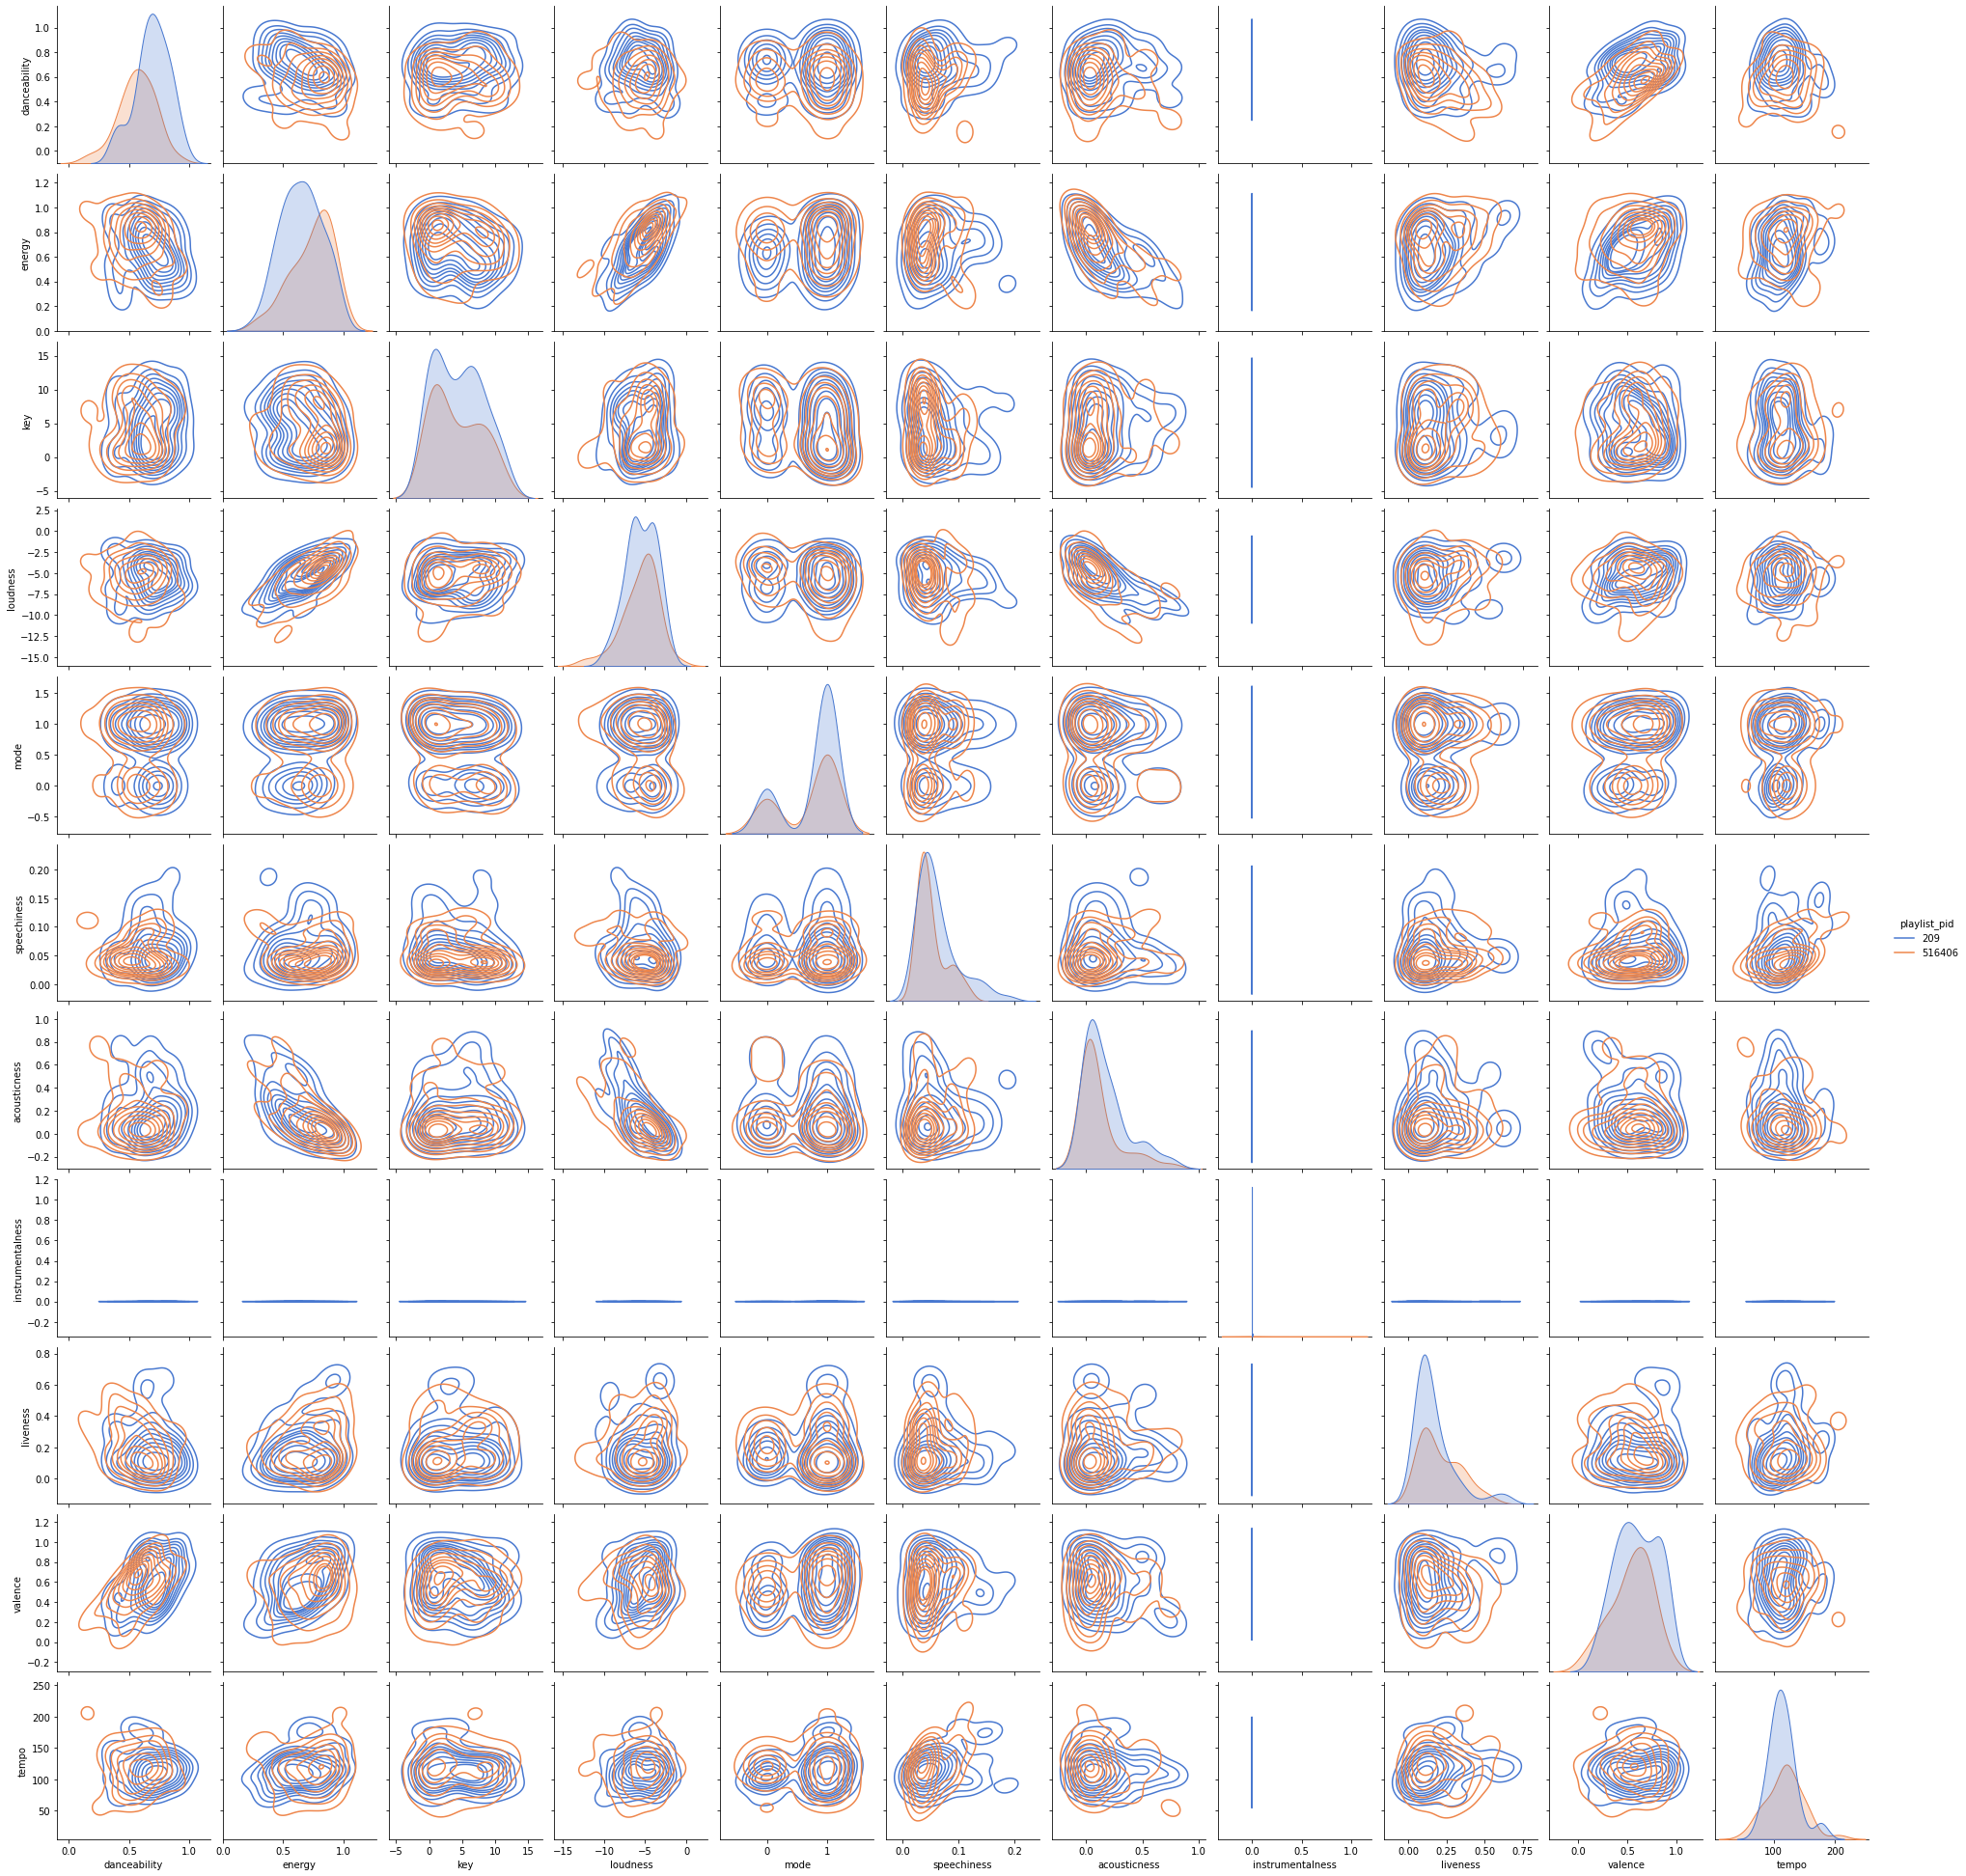

In [266]:
check_result_sim(209,516406)

/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarn

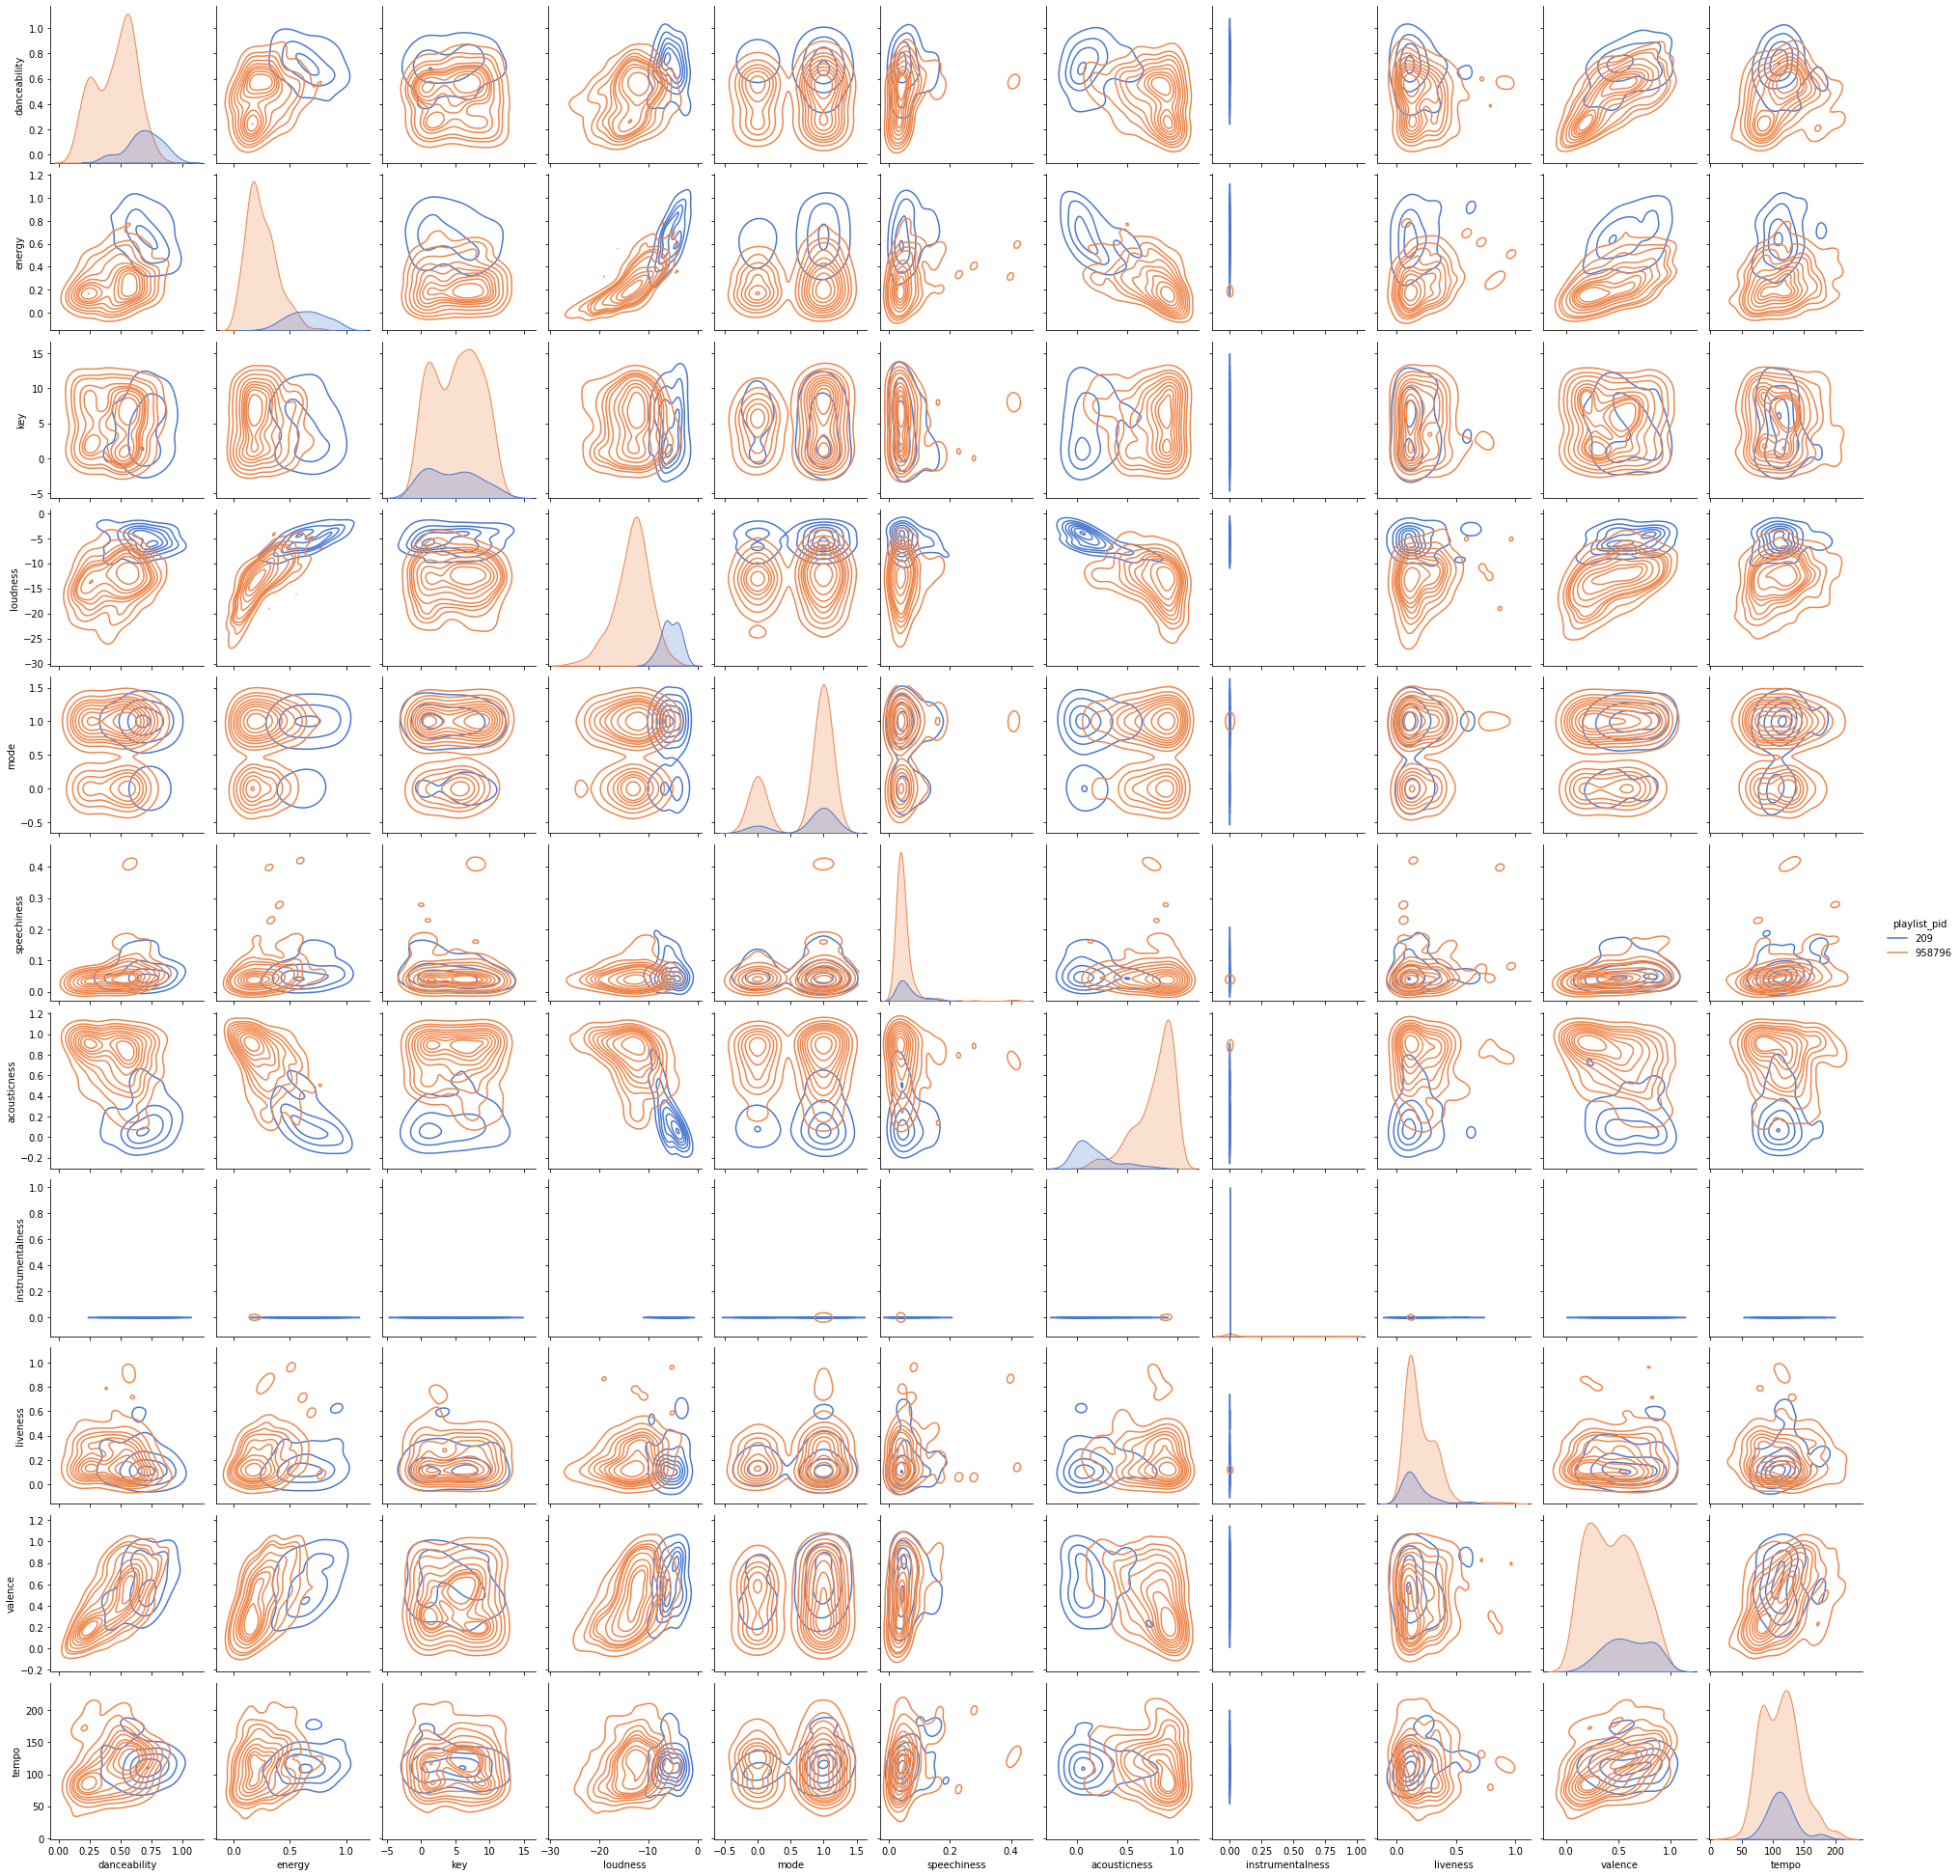

In [273]:
check_result_sim(209,958796)

In [454]:
def cv_r_precision (pid):
    score_cv = []
    for j in range(5):
        df_groundtruth = df_similarity[df_similarity['playlist_pid'] == pid]
        X, y = train_test_split(df_groundtruth, test_size=0.3, random_state=j)
        print ('done with setting up data')
        l = similarity_vector(X,pid, 'matrix norms')
        df_sim_result = pd.DataFrame(l)
        print ('done similarities for playlist', pid)
        top_sim_list = list(df_sim_result.sort_values("similarity").head(100).pid_2)+list(df_sim_result.sort_values("similarity").tail(10).pid_2)
        track_similar = track_similarity(X,top_sim_list)
        df_track = pd.DataFrame(track_similar)
        print ('done getting track recommendations for playlist', pid)
        lst1 = list(y.track_uri) 
        lst2 = list(df_track.sort_values("similarity").head(400).track_uri) + list(df_track.sort_values("similarity").tail(100).track_uri)
        score, _ = r_precision(lst1,lst2)
        print ('r precision for playlist:', pid, 'is', score)
        score_cv.append(score)
        print ('done with',j,  'iteration for playlist:', pid)
    return [np.mean(score_cv),pid]

In [455]:
r_scores = []
unique_playlist = list(df['playlist_pid'].unique())
df_similarity = df[feature_list + ['playlist_pid','track_uri']]
df_similarity = df_similarity.dropna()
# for i in unique_playlist:
#     r_scores.append(cv_r_precision(i))
# avg_rp = np.mean(r_scores)

done with setting up data
done similarities for playlist 516000
done getting track recommendations for playlist 516000
r precision for playlist: 516000 is 0.0
done with 0 iteration for playlist: 516000
done with setting up data


KeyboardInterrupt: 

In [458]:
from concurrent.futures import ProcessPoolExecutor

r_scores = []
f = open("result.txt", "w+")
with ProcessPoolExecutor(max_workers=6) as executor:
    for r in executor.map(cv_r_precision, unique_playlist):
        r_scores.append(r[0])
        s = str(r[1]) + ',' + r[0] + '\n'
        print (s)
        f.write(s)
avg_rp = np.mean(r_scores)
f.close()
print (avg_rp)

done with setting up data
done with setting up data
done with setting up data
done with setting up datadone with setting up data

done with setting up data
done similarities for playlist 516000
done similarities for playlist 516404
done similarities for playlist 516751
done getting track recommendations for playlist 516000
r precision for playlist: 516000 is 0.0
done with 0 iteration for playlist: 516000
done with setting up data
done getting track recommendations for playlist 516751
r precision for playlist: 516751 is 0.0
done with 0 iteration for playlist: 516751
done with setting up data
done getting track recommendations for playlist 516404
r precision for playlist: 516404 is 0.0
done with 0 iteration for playlist: 516404
done with setting up data
done similarities for playlist 516928
done similarities for playlist 516828
done similarities for playlist 516217
done getting track recommendations for playlist 516928
r precision for playlist: 516928 is 0.0
done with 0 iteration for pla

KeyboardInterrupt: 


done similarities for playlist 516071
done similarities for playlist 516851
done getting track recommendations for playlist 516851
r precision for playlist: 516851 is 0.027777777777777776
done with 0 iteration for playlist: 516851
done with setting up data
done getting track recommendations for playlist 516071
r precision for playlist: 516071 is 0.03333333333333333
done with 0 iteration for playlist: 516071
done with setting up data
done similarities for playlist 516071
done similarities for playlist 516851
done getting track recommendations for playlist 516071
r precision for playlist: 516071 is 0.1
done with 1 iteration for playlist: 516071
done with setting up data
done getting track recommendations for playlist 516851
r precision for playlist: 516851 is 0.0
done with 1 iteration for playlist: 516851
done with setting up data
done similarities for playlist 516071
done similarities for playlist 516851
done getting track recommendations for playlist 516071
r precision for playlist: 5